In [ ]:
# imports needed for pytorch tinyBERT project

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss, MSELoss

import csv
import logging
import os
import random
import sys
import copy


# Download Dataset and Model

TinyBert github: https://github.com/huawei-noah/Pretrained-Language-Model/tree/master/TinyBERT

In [ ]:
# downloading dataset
!git clone https://github.com/nyu-mll/GLUE-baselines.git
!python GLUE-baselines/download_glue_data.py --data_dir /content --tasks SST

Cloning into 'GLUE-baselines'...
remote: Enumerating objects: 891, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 891 (delta 1), reused 3 (delta 1), pack-reused 886 (from 1)
Receiving objects: 100% (891/891), 1.48 MiB | 25.64 MiB/s, done.
Resolving deltas: 100% (610/610), done.
	Completed!


In [ ]:
# download tinyBERT source code and install dependencies
!git clone https://github.com/huawei-noah/Pretrained-Language-Model.git

Cloning into 'Pretrained-Language-Model'...
remote: Enumerating objects: 1253, done.
remote: Counting objects: 100% (280/280), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 1253 (delta 173), reused 120 (delta 119), pack-reused 973 (from 1)
Receiving objects: 100% (1253/1253), 29.72 MiB | 16.72 MiB/s, done.
Resolving deltas: 100% (540/540), done.


In [ ]:
%cd Pretrained-Language-Model/TinyBERT
!pip install -r requirements.txt

/content/Pretrained-Language-Model/TinyBERT
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 9.6 MB/s eta 0:00:00


# Setup and Dependencies

In [ ]:
SEED = 42
torch.backends.cudnn.deterministic = True
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
print('Installing torchprofile...')
!pip install torchprofile 1>/dev/null
print('Installing fast-pytorch-kmeans...')
! pip install fast-pytorch-kmeans 1>/dev/null
print('All required packages have been successfully installed!')

Installing torchprofile...
Installing fast-pytorch-kmeans...
All required packages have been successfully installed!


In [ ]:
from torchprofile import profile_macs
from torch import nn

In [ ]:
# downloading BERT-base code: https://github.com/google-research/bert?tab=readme-ov-file
!wget https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip
!unzip cased_L-12_H-768_A-12.zip
!cp cased_L-12_H-768_A-12/bert_config.json cased_L-12_H-768_A-12/config.json # must rename bert_config to config

BERT_BASE_DIR = 'cased_L-12_H-768_A-12'

--2024-12-14 19:59:38--  https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 404261442 (386M) [application/zip]
Saving to: ‘cased_L-12_H-768_A-12.zip’

cased_L-12_H-768_A- 100%[===================>] 385.53M  21.1MB/s    in 20s     

2024-12-14 19:59:58 (19.5 MB/s) - ‘cased_L-12_H-768_A-12.zip’ saved [404261442/404261442]

Archive:  cased_L-12_H-768_A-12.zip
   creating: cased_L-12_H-768_A-12/
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: cased_L-12_H-768_A-12/vocab.txt  
  inflating: cased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: cased_L-12_H-768_A-12/bert_config.json  


In [ ]:
# cloning TinyBert pretrained models
!git clone https://huggingface.co/huawei-noah/TinyBERT_General_4L_312D

STUDENT_CONFIG_DIR = '/content/Pretrained-Language-Model/TinyBERT/TinyBERT_General_4L_312D'

Cloning into 'TinyBERT_General_4L_312D'...
remote: Enumerating objects: 24, done.
remote: Total 24 (delta 0), reused 0 (delta 0), pack-reused 24 (from 1)
Unpacking objects: 100% (24/24), 111.20 KiB | 7.41 MiB/s, done.


In [ ]:
def get_model_size(model: nn.Module, data_width=32):
    """
    calculate the model size in bits
    :param data_width: #bits per element
    """
    num_elements = 0
    for param in model.parameters():
        num_elements += param.numel()
    return num_elements * data_width

Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB

# Load up Distilled Model

In [ ]:
from transformer.modeling import TinyBertForPreTraining, BertModel, TinyBertForSequenceClassification

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DISTILLED_CONFIG_DIR = "/content/drive/MyDrive/EAPS Research/MEng/classes/tinyML/TinyML Final Project/tinybert_output_final_maybe"

In [ ]:
num_labels = 2
student_model = TinyBertForSequenceClassification.from_pretrained(DISTILLED_CONFIG_DIR, num_labels=num_labels)

/content/Pretrained-Language-Model/TinyBERT/transformer/modeling.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location='cp

# How large is the distilled TinyBert?

In [ ]:
# STORAGE
student_model_size = get_model_size(student_model)

print("Student model size: ", student_model_size/MiB, "MiB")


Student model size:  54.741851806640625 MiB


# Evaluating Distilled TinyBert

In [ ]:
from task_distill import convert_examples_to_features, get_tensor_data, InputExample, InputFeatures, DataProcessor, Sst2Processor
from torch.utils.data import SequentialSampler
from transformer.modeling import TinyBertForPreTraining, BertModel, TinyBertForSequenceClassification

In [ ]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return {"acc": simple_accuracy(preds, labels)}

# evaluation function based on  task_distill.py --do_eval
def evaluate_tinybert(model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels):
    eval_loss = 0
    nb_eval_steps = 0
    preds = []

    model.eval()
    for batch_ in tqdm(eval_dataloader, desc="Evaluating"):
        batch_ = tuple(t.to(device) for t in batch_)
        with torch.no_grad():
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch_

            # ValueError: not enough values to unpack (expected 3, got 2)
            # logits, _, _ = model(input_ids, segment_ids, input_mask)
            # TODO: what is the model outputting? What
            logits, _ , _= model(input_ids, segment_ids, input_mask)


        # create eval loss and other metric required by the task
        if output_mode == "classification":
            loss_fct = CrossEntropyLoss()
            tmp_eval_loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
        elif output_mode == "regression":
            loss_fct = MSELoss()
            tmp_eval_loss = loss_fct(logits.view(-1), label_ids.view(-1))

        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if len(preds) == 0:
            preds.append(logits.detach().cpu().numpy())
        else:
            preds[0] = np.append(
                preds[0], logits.detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps

    preds = preds[0]
    if output_mode == "classification":
        preds = np.argmax(preds, axis=1)
    elif output_mode == "regression":
        preds = np.squeeze(preds)
    result = compute_metrics(task_name, preds, eval_labels.numpy())
    result['eval_loss'] = eval_loss

    return result


output_mode = "classification"


In [ ]:
# building the evaluation dataloader
do_lower_case = False
data_dir = '/content/SST-2'
processor = Sst2Processor()
label_list = processor.get_labels()
num_labels = len(label_list)
max_seq_length = 128
eval_batch_size = 32
task_name = "sst2"
output_mode = "classification"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# student_model = TinyBertForSequenceClassification.from_pretrained(DISTILLED_CONFIG_DIR, num_labels=num_labels)
student_model.to(device)

tokenizer = BertTokenizer.from_pretrained(STUDENT_CONFIG_DIR, do_lower_case=do_lower_case)
eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

# check that the evaluate_tinybert function is working
evaluate_tinybert(student_model, task_name, eval_dataloader,
            device, output_mode, eval_labels, num_labels)


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 126.26it/s]


{'acc': 0.5091743119266054, 'eval_loss': 0.6922517525298255}

In [ ]:
# method that both sets up the dataset and runs evaluation on TinyBert
def evaluate(student_model):
  # building the evaluation dataloader
  do_lower_case = False
  data_dir = '/content/SST-2'
  processor = Sst2Processor()
  label_list = processor.get_labels()
  num_labels = len(label_list)
  max_seq_length = 128
  eval_batch_size = 32
  task_name = "sst2"
  output_mode = "classification"
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  student_model.to(device)

  #TODO: does this tokenizer still work?
  tokenizer = BertTokenizer.from_pretrained(STUDENT_CONFIG_DIR, do_lower_case=do_lower_case)
  eval_examples = processor.get_dev_examples(data_dir)
  eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
  eval_data, eval_labels = get_tensor_data(output_mode, eval_features)
  eval_sampler = SequentialSampler(eval_data)
  eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

  res = evaluate_tinybert(student_model, task_name, eval_dataloader,
              device, output_mode, eval_labels, num_labels)
  return res

# Finetuning

In [ ]:
def train_tinybert(
    model,
    task_name,
    train_dataloader,
    eval_dataloader,
    device,
    output_mode,
    num_labels,
    eval_labels,
    optimizer=None,
    scheduler=None,
    epochs=3
):
    """
    Fine-tune a TinyBERT model with training and validation metrics history.

    Args:
        model: The TinyBERT model to be fine-tuned.
        task_name: Name of the task (used for metric computation).
        train_dataloader: DataLoader for training data.
        eval_dataloader: DataLoader for evaluation data.
        device: Device to train on (e.g., 'cpu' or 'cuda').
        output_mode: Output mode for the task ('classification' or 'regression').
        num_labels: Number of labels for classification tasks.
        eval_labels: Ground truth labels for the evaluation set.
        optimizer: Optimizer for training (default is AdamW).
        scheduler: Learning rate scheduler (optional).
        epochs: Number of training epochs.

    Returns:
        model: The fine-tuned model with a `history` attribute.
    """
    # Initialize optimizer if none is provided
    if optimizer is None:
        optimizer = AdamW(model.parameters(), lr=5e-5)

    # Initialize or extend model's history attribute
    if not hasattr(model, 'history'):
        model.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Move model to the specified device
    model.to(device)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0  # To track total training loss
        nb_train_steps = 0  # To count the number of training steps
        correct_predictions = 0
        total_predictions = 0

        print(f"Epoch {epoch + 1}/{epochs}")

        # Training step
        for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
            # Move each tensor in the batch to the device
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch

            # Zero the gradients to prevent accumulation
            optimizer.zero_grad()

            # Forward pass
            logits, _, _ = model(input_ids, segment_ids, input_mask)

            # Compute loss
            if output_mode == "classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
                preds = torch.argmax(logits, dim=1)
            elif output_mode == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), label_ids.view(-1))
                preds = logits.squeeze()
            else:
                raise ValueError(f"Unknown output mode: {output_mode}")

            # Update metrics
            if output_mode == "classification":
                correct_predictions += (preds == label_ids).sum().item()
                total_predictions += label_ids.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update training metrics
            total_loss += loss.item()
            nb_train_steps += 1

        # Adjust learning rate with scheduler (if provided)
        if scheduler:
            scheduler.step()

        # Compute training metrics
        avg_train_loss = total_loss / nb_train_steps
        train_accuracy = correct_predictions / total_predictions if output_mode == "classification" else None
        print(f"Training loss: {avg_train_loss:.4f}")
        if train_accuracy is not None:
            print(f"Training accuracy: {train_accuracy:.4f}")

        # Evaluate the model
        eval_result = evaluate_tinybert(
            model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels
        )
        avg_val_loss = eval_result['eval_loss']
        val_accuracy = eval_result['acc']

        # Print validation results
        print(f"Validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f}")

        # Update the model's history
        model.history['train_loss'].append(avg_train_loss)
        model.history['val_loss'].append(avg_val_loss)
        if train_accuracy is not None:
            model.history['train_acc'].append(train_accuracy)
        model.history['val_acc'].append(val_accuracy)

    return model


In [ ]:
# building the train and evaluation dataloader
do_lower_case = False
data_dir = '/content/SST-2'
processor = Sst2Processor()
label_list = processor.get_labels()
num_labels = len(label_list)
max_seq_length = 128
eval_batch_size = 32
train_batch_size = 32
task_name = "sst2"
output_mode = "classification"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = TinyBertForSequenceClassification.from_pretrained(STUDENT_CONFIG_DIR, num_labels=num_labels)
student_model.to(device)

tokenizer = BertTokenizer.from_pretrained(STUDENT_CONFIG_DIR, do_lower_case=do_lower_case)
eval_examples = processor.get_dev_examples(data_dir)
eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
eval_data, eval_labels = get_tensor_data(output_mode, eval_features)
eval_sampler = SequentialSampler(eval_data)
eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

train_examples = processor.get_train_examples(data_dir)
train_features = convert_examples_to_features(train_examples, label_list, max_seq_length, tokenizer, output_mode)
train_data, train_labels = get_tensor_data(output_mode, train_features)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

# only train for 1 epoch - overfits fast
student_model = train_tinybert(
    student_model,
    task_name,
    train_dataloader,
    eval_dataloader,
    device,
    output_mode,
    num_labels,
    eval_labels,
    optimizer=None,
    scheduler=None,
    epochs=1
)

# SAVE MODEL
model_path = '/content/tinyBert_sst2.pt'
torch.save(student_model.state_dict(), model_path)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


Training: 100%|██████████| 2105/2105 [00:49<00:00, 42.88it/s]


Training loss: 0.2801
Training accuracy: 0.8869


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 147.30it/s]


Validation loss: 0.2811
Validation accuracy: 0.8922


In [ ]:
# putting the dataset prep and training into one function

def train_tinybert_sst2(student_model):
  # building the train and evaluation dataloader
  do_lower_case = False
  data_dir = '/content/SST-2'
  processor = Sst2Processor()
  label_list = processor.get_labels()
  num_labels = len(label_list)
  max_seq_length = 128
  eval_batch_size = 32
  train_batch_size = 32
  task_name = "sst2"
  output_mode = "classification"
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # student_model = TinyBertForSequenceClassification.from_pretrained(STUDENT_CONFIG_DIR, num_labels=num_labels)
  student_model.to(device)

  tokenizer = BertTokenizer.from_pretrained(STUDENT_CONFIG_DIR, do_lower_case=do_lower_case)
  eval_examples = processor.get_dev_examples(data_dir)
  eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
  eval_data, eval_labels = get_tensor_data(output_mode, eval_features)
  eval_sampler = SequentialSampler(eval_data)
  eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

  train_examples = processor.get_train_examples(data_dir)
  train_features = convert_examples_to_features(train_examples, label_list, max_seq_length, tokenizer, output_mode)
  train_data, train_labels = get_tensor_data(output_mode, train_features)
  train_sampler = SequentialSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

  # only train for 1 epoch - overfits fast
  student_model = train_tinybert(
      student_model,
      task_name,
      train_dataloader,
      eval_dataloader,
      device,
      output_mode,
      num_labels,
      eval_labels,
      optimizer=None,
      scheduler=None,
      epochs=1
  )
  return student_model

# Fine-grain Pruning

## Fine-grain Pruning Functions

In [ ]:
def get_sparsity(tensor: torch.Tensor) -> float:
    """
    calculate the sparsity of the given tensor
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    return 1 - float(tensor.count_nonzero()) / tensor.numel()


def get_model_sparsity(model: nn.Module) -> float:
    """
    calculate the sparsity of the given model
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    """
    num_nonzeros, num_elements = 0, 0
    for param in model.parameters():
        num_nonzeros += param.count_nonzero()
        num_elements += param.numel()
    return 1 - float(num_nonzeros) / num_elements

def get_num_parameters(model: nn.Module, count_nonzero_only=False) -> int:
    """
    calculate the total number of parameters of model
    :param count_nonzero_only: only count nonzero weights
    """
    num_counted_elements = 0
    for param in model.parameters():
        if count_nonzero_only:
            num_counted_elements += param.count_nonzero()
        else:
            num_counted_elements += param.numel()
    return num_counted_elements


def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    # print("num_elements", num_elements)
    # print("sparsity", sparsity)
    num_zeros = round(num_elements * sparsity)
    # print("num_zeros", num_zeros)
    # Step 2: calculate the importance of weight
    importance = torch.Tensor.abs(tensor)
    # Step 3: calculate the pruning threshold
    # print("importance", torch.flatten(importance))
    threshold = torch.kthvalue(torch.flatten(importance), num_zeros).values
    # print("threshold", threshold)
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = torch.gt(importance, threshold)
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

In [ ]:
class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

In [ ]:
def get_model_size(model: nn.Module, data_width=32, count_nonzero_only=False) -> int:
    """
    calculate the model size in bits
    :param data_width: #bits per element
    :param count_nonzero_only: only count nonzero weights
    """
    return get_num_parameters(model, count_nonzero_only) * data_width

## Test Fine-grain pruning

In [ ]:
# evaluate the Accuracy and Model Size of Dense Model
dense_model_accuracy = evaluate(student_model)['acc'] *100
dense_model_size = get_model_size(student_model)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

dense_model = copy.deepcopy(student_model)

Evaluating: 100%|██████████| 28/28 [00:00<00:00, 119.47it/s]

dense model has accuracy=89.22%
dense model has size=55.66 MiB


## Sensitivity Scan to determine optimal sparsities for each layer

In [ ]:
@torch.no_grad()
def sensitivity_scan(model, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model)['acc']*100
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [ ]:
sparsities, accuracies = sensitivity_scan(
    student_model, scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/30 weight - bert.embeddings.word_embeddings.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 122.59it/s]
scanning 0/30 weight - bert.embeddings.word_embeddings.weight:  17%|█▋        | 1/6 [00:00<00:03,  1.32it/s]

    sparsity=0.40: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.79it/s]
scanning 0/30 weight - bert.embeddings.word_embeddings.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.55it/s]

    sparsity=0.50: accuracy=88.53%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.99it/s]
scanning 0/30 weight - bert.embeddings.word_embeddings.weight:  50%|█████     | 3/6 [00:01<00:01,  1.64it/s]

    sparsity=0.60: accuracy=87.39%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.91it/s]
scanning 0/30 weight - bert.embeddings.word_embeddings.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.69it/s]

    sparsity=0.70: accuracy=86.12%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.40it/s]
scanning 0/30 weight - bert.embeddings.word_embeddings.weight:  83%|████████▎ | 5/6 [00:03<00:00,  1.72it/s]

    sparsity=0.80: accuracy=83.03%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.78it/s]
scanning 0/30 weight - bert.embeddings.word_embeddings.weight: 100%|██████████| 6/6 [00:03<00:00,  1.68it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.33%, 88.53%, 87.39%, 86.12%, 83.03%, 80.05%]

scanning 1/30 weight - bert.embeddings.position_embeddings.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.96it/s]
scanning 1/30 weight - bert.embeddings.position_embeddings.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.76it/s]

    sparsity=0.40: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.91it/s]
scanning 1/30 weight - bert.embeddings.position_embeddings.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.78it/s]

    sparsity=0.50: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.04it/s]
scanning 1/30 weight - bert.embeddings.position_embeddings.weight:  50%|█████     | 3/6 [00:01<00:01,  1.79it/s]

    sparsity=0.60: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.91it/s]
scanning 1/30 weight - bert.embeddings.position_embeddings.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.79it/s]

    sparsity=0.70: accuracy=89.56%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.99it/s]
scanning 1/30 weight - bert.embeddings.position_embeddings.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.79it/s]

    sparsity=0.80: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 140.46it/s]
scanning 1/30 weight - bert.embeddings.position_embeddings.weight: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.11%, 89.22%, 89.22%, 89.56%, 89.33%, 87.50%]

scanning 2/30 weight - bert.embeddings.token_type_embeddings.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.06it/s]
scanning 2/30 weight - bert.embeddings.token_type_embeddings.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.80it/s]

    sparsity=0.40: accuracy=88.42%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.25it/s]
scanning 2/30 weight - bert.embeddings.token_type_embeddings.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.79it/s]

    sparsity=0.50: accuracy=88.19%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.89it/s]
scanning 2/30 weight - bert.embeddings.token_type_embeddings.weight:  50%|█████     | 3/6 [00:01<00:01,  1.79it/s]

    sparsity=0.60: accuracy=88.76%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.61it/s]
scanning 2/30 weight - bert.embeddings.token_type_embeddings.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.79it/s]

    sparsity=0.70: accuracy=88.65%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.86it/s]
scanning 2/30 weight - bert.embeddings.token_type_embeddings.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.80it/s]

    sparsity=0.80: accuracy=86.47%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 146.27it/s]
scanning 2/30 weight - bert.embeddings.token_type_embeddings.weight: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[88.42%, 88.19%, 88.76%, 88.65%, 86.47%, 85.89%]

scanning 3/30 weight - bert.encoder.layer.0.attention.self.query.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.50it/s]
scanning 3/30 weight - bert.encoder.layer.0.attention.self.query.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.79it/s]

    sparsity=0.40: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.75it/s]
scanning 3/30 weight - bert.encoder.layer.0.attention.self.query.weight:  33%|███▎      | 2/6 [00:01<00:03,  1.18it/s]

    sparsity=0.50: accuracy=88.53%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 140.77it/s]
scanning 3/30 weight - bert.encoder.layer.0.attention.self.query.weight:  50%|█████     | 3/6 [00:02<00:02,  1.39it/s]

    sparsity=0.60: accuracy=88.65%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.87it/s]
scanning 3/30 weight - bert.encoder.layer.0.attention.self.query.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.52it/s]

    sparsity=0.70: accuracy=88.65%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.21it/s]
scanning 3/30 weight - bert.encoder.layer.0.attention.self.query.weight:  83%|████████▎ | 5/6 [00:03<00:00,  1.61it/s]

    sparsity=0.80: accuracy=88.53%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 136.59it/s]
scanning 3/30 weight - bert.encoder.layer.0.attention.self.query.weight: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[88.99%, 88.53%, 88.65%, 88.65%, 88.53%, 88.07%]

scanning 4/30 weight - bert.encoder.layer.0.attention.self.key.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.62it/s]
scanning 4/30 weight - bert.encoder.layer.0.attention.self.key.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.77it/s]

    sparsity=0.40: accuracy=88.88%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.91it/s]
scanning 4/30 weight - bert.encoder.layer.0.attention.self.key.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.78it/s]

    sparsity=0.50: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 141.00it/s]
scanning 4/30 weight - bert.encoder.layer.0.attention.self.key.weight:  50%|█████     | 3/6 [00:01<00:01,  1.78it/s]

    sparsity=0.60: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.91it/s]
scanning 4/30 weight - bert.encoder.layer.0.attention.self.key.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.78it/s]

    sparsity=0.70: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 140.46it/s]
scanning 4/30 weight - bert.encoder.layer.0.attention.self.key.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.78it/s]

    sparsity=0.80: accuracy=88.42%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.67it/s]
scanning 4/30 weight - bert.encoder.layer.0.attention.self.key.weight: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[88.88%, 89.11%, 89.22%, 89.22%, 88.42%, 86.81%]

scanning 5/30 weight - bert.encoder.layer.0.attention.self.value.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.09it/s]
scanning 5/30 weight - bert.encoder.layer.0.attention.self.value.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]

    sparsity=0.40: accuracy=88.53%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.39it/s]
scanning 5/30 weight - bert.encoder.layer.0.attention.self.value.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.78it/s]

    sparsity=0.50: accuracy=88.19%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.51it/s]
scanning 5/30 weight - bert.encoder.layer.0.attention.self.value.weight:  50%|█████     | 3/6 [00:01<00:01,  1.78it/s]

    sparsity=0.60: accuracy=87.96%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.25it/s]
scanning 5/30 weight - bert.encoder.layer.0.attention.self.value.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.79it/s]

    sparsity=0.70: accuracy=88.42%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 103.58it/s]
scanning 5/30 weight - bert.encoder.layer.0.attention.self.value.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.70it/s]

    sparsity=0.80: accuracy=87.04%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.62it/s]
scanning 5/30 weight - bert.encoder.layer.0.attention.self.value.weight: 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[88.53%, 88.19%, 87.96%, 88.42%, 87.04%, 85.78%]

scanning 6/30 weight - bert.encoder.layer.0.attention.output.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.55it/s]
scanning 6/30 weight - bert.encoder.layer.0.attention.output.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.80it/s]

    sparsity=0.40: accuracy=88.76%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.22it/s]
scanning 6/30 weight - bert.encoder.layer.0.attention.output.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.80it/s]

    sparsity=0.50: accuracy=88.42%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.42it/s]
scanning 6/30 weight - bert.encoder.layer.0.attention.output.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.80it/s]

    sparsity=0.60: accuracy=88.19%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.47it/s]
scanning 6/30 weight - bert.encoder.layer.0.attention.output.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.80it/s]

    sparsity=0.70: accuracy=87.61%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.46it/s]
scanning 6/30 weight - bert.encoder.layer.0.attention.output.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.79it/s]

    sparsity=0.80: accuracy=88.30%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.44it/s]
scanning 6/30 weight - bert.encoder.layer.0.attention.output.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[88.76%, 88.42%, 88.19%, 87.61%, 88.30%, 87.04%]

scanning 7/30 weight - bert.encoder.layer.0.intermediate.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.54it/s]
scanning 7/30 weight - bert.encoder.layer.0.intermediate.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.75it/s]

    sparsity=0.40: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.15it/s]
scanning 7/30 weight - bert.encoder.layer.0.intermediate.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.77it/s]

    sparsity=0.50: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.04it/s]
scanning 7/30 weight - bert.encoder.layer.0.intermediate.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.77it/s]

    sparsity=0.60: accuracy=88.53%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.40it/s]
scanning 7/30 weight - bert.encoder.layer.0.intermediate.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.77it/s]

    sparsity=0.70: accuracy=87.61%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.17it/s]
scanning 7/30 weight - bert.encoder.layer.0.intermediate.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.76it/s]

    sparsity=0.80: accuracy=87.16%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.57it/s]
scanning 7/30 weight - bert.encoder.layer.0.intermediate.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[88.99%, 89.33%, 88.53%, 87.61%, 87.16%, 83.14%]

scanning 8/30 weight - bert.encoder.layer.0.output.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.02it/s]
scanning 8/30 weight - bert.encoder.layer.0.output.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.76it/s]

    sparsity=0.40: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.77it/s]
scanning 8/30 weight - bert.encoder.layer.0.output.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.78it/s]

    sparsity=0.50: accuracy=88.42%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.51it/s]
scanning 8/30 weight - bert.encoder.layer.0.output.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.78it/s]

    sparsity=0.60: accuracy=88.65%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.02it/s]
scanning 8/30 weight - bert.encoder.layer.0.output.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.78it/s]

    sparsity=0.70: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.99it/s]
scanning 8/30 weight - bert.encoder.layer.0.output.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.79it/s]

    sparsity=0.80: accuracy=88.65%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.73it/s]
scanning 8/30 weight - bert.encoder.layer.0.output.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.22%, 88.42%, 88.65%, 89.33%, 88.65%, 86.93%]

scanning 9/30 weight - bert.encoder.layer.1.attention.self.query.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.30it/s]
scanning 9/30 weight - bert.encoder.layer.1.attention.self.query.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]

    sparsity=0.40: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.03it/s]
scanning 9/30 weight - bert.encoder.layer.1.attention.self.query.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.78it/s]

    sparsity=0.50: accuracy=89.79%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.25it/s]
scanning 9/30 weight - bert.encoder.layer.1.attention.self.query.weight:  50%|█████     | 3/6 [00:01<00:01,  1.78it/s]

    sparsity=0.60: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.49it/s]
scanning 9/30 weight - bert.encoder.layer.1.attention.self.query.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.79it/s]

    sparsity=0.70: accuracy=89.45%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.12it/s]
scanning 9/30 weight - bert.encoder.layer.1.attention.self.query.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.79it/s]

    sparsity=0.80: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.10it/s]
scanning 9/30 weight - bert.encoder.layer.1.attention.self.query.weight: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.11%, 89.79%, 89.11%, 89.45%, 89.33%, 87.27%]

scanning 10/30 weight - bert.encoder.layer.1.attention.self.key.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.07it/s]
scanning 10/30 weight - bert.encoder.layer.1.attention.self.key.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.80it/s]

    sparsity=0.40: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.37it/s]
scanning 10/30 weight - bert.encoder.layer.1.attention.self.key.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.80it/s]

    sparsity=0.50: accuracy=89.45%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.01it/s]
scanning 10/30 weight - bert.encoder.layer.1.attention.self.key.weight:  50%|█████     | 3/6 [00:01<00:01,  1.80it/s]

    sparsity=0.60: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.38it/s]
scanning 10/30 weight - bert.encoder.layer.1.attention.self.key.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.80it/s]

    sparsity=0.70: accuracy=88.53%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.53it/s]
scanning 10/30 weight - bert.encoder.layer.1.attention.self.key.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.79it/s]

    sparsity=0.80: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.47it/s]
scanning 10/30 weight - bert.encoder.layer.1.attention.self.key.weight: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.33%, 89.45%, 89.22%, 88.53%, 88.99%, 88.07%]

scanning 11/30 weight - bert.encoder.layer.1.attention.self.value.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.60it/s]
scanning 11/30 weight - bert.encoder.layer.1.attention.self.value.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]

    sparsity=0.40: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 138.82it/s]
scanning 11/30 weight - bert.encoder.layer.1.attention.self.value.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.75it/s]

    sparsity=0.50: accuracy=89.45%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.69it/s]
scanning 11/30 weight - bert.encoder.layer.1.attention.self.value.weight:  50%|█████     | 3/6 [00:01<00:01,  1.77it/s]

    sparsity=0.60: accuracy=89.91%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.50it/s]
scanning 11/30 weight - bert.encoder.layer.1.attention.self.value.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.78it/s]

    sparsity=0.70: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.21it/s]
scanning 11/30 weight - bert.encoder.layer.1.attention.self.value.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.78it/s]

    sparsity=0.80: accuracy=88.30%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.94it/s]
scanning 11/30 weight - bert.encoder.layer.1.attention.self.value.weight: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.33%, 89.45%, 89.91%, 89.22%, 88.30%, 86.24%]

scanning 12/30 weight - bert.encoder.layer.1.attention.output.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 146.16it/s]
scanning 12/30 weight - bert.encoder.layer.1.attention.output.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.79it/s]

    sparsity=0.40: accuracy=89.68%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.19it/s]
scanning 12/30 weight - bert.encoder.layer.1.attention.output.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.78it/s]

    sparsity=0.50: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.19it/s]
scanning 12/30 weight - bert.encoder.layer.1.attention.output.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.79it/s]

    sparsity=0.60: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.11it/s]
scanning 12/30 weight - bert.encoder.layer.1.attention.output.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.79it/s]

    sparsity=0.70: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.89it/s]
scanning 12/30 weight - bert.encoder.layer.1.attention.output.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.79it/s]

    sparsity=0.80: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.52it/s]
scanning 12/30 weight - bert.encoder.layer.1.attention.output.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.68%, 89.33%, 89.22%, 89.33%, 89.33%, 88.30%]

scanning 13/30 weight - bert.encoder.layer.1.intermediate.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.69it/s]
scanning 13/30 weight - bert.encoder.layer.1.intermediate.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.75it/s]

    sparsity=0.40: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.97it/s]
scanning 13/30 weight - bert.encoder.layer.1.intermediate.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.77it/s]

    sparsity=0.50: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.99it/s]
scanning 13/30 weight - bert.encoder.layer.1.intermediate.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.78it/s]

    sparsity=0.60: accuracy=88.53%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.44it/s]
scanning 13/30 weight - bert.encoder.layer.1.intermediate.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.78it/s]

    sparsity=0.70: accuracy=88.53%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.81it/s]
scanning 13/30 weight - bert.encoder.layer.1.intermediate.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.77it/s]

    sparsity=0.80: accuracy=88.65%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 104.34it/s]
scanning 13/30 weight - bert.encoder.layer.1.intermediate.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.33%, 89.22%, 88.53%, 88.53%, 88.65%, 86.01%]

scanning 14/30 weight - bert.encoder.layer.1.output.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 139.03it/s]
scanning 14/30 weight - bert.encoder.layer.1.output.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.76it/s]

    sparsity=0.40: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.22it/s]
scanning 14/30 weight - bert.encoder.layer.1.output.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.78it/s]

    sparsity=0.50: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.09it/s]
scanning 14/30 weight - bert.encoder.layer.1.output.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.76it/s]

    sparsity=0.60: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.82it/s]
scanning 14/30 weight - bert.encoder.layer.1.output.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.75it/s]

    sparsity=0.70: accuracy=89.68%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 141.75it/s]
scanning 14/30 weight - bert.encoder.layer.1.output.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.75it/s]

    sparsity=0.80: accuracy=88.76%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 117.23it/s]
scanning 14/30 weight - bert.encoder.layer.1.output.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.22%, 89.11%, 89.22%, 89.68%, 88.76%, 87.39%]

scanning 15/30 weight - bert.encoder.layer.2.attention.self.query.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 124.18it/s]
scanning 15/30 weight - bert.encoder.layer.2.attention.self.query.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.67it/s]

    sparsity=0.40: accuracy=88.88%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.70it/s]
scanning 15/30 weight - bert.encoder.layer.2.attention.self.query.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.73it/s]

    sparsity=0.50: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.41it/s]
scanning 15/30 weight - bert.encoder.layer.2.attention.self.query.weight:  50%|█████     | 3/6 [00:01<00:01,  1.75it/s]

    sparsity=0.60: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.81it/s]
scanning 15/30 weight - bert.encoder.layer.2.attention.self.query.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.75it/s]

    sparsity=0.70: accuracy=88.65%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 135.37it/s]
scanning 15/30 weight - bert.encoder.layer.2.attention.self.query.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.73it/s]

    sparsity=0.80: accuracy=88.30%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.56it/s]
scanning 15/30 weight - bert.encoder.layer.2.attention.self.query.weight: 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[88.88%, 88.99%, 88.99%, 88.65%, 88.30%, 88.76%]

scanning 16/30 weight - bert.encoder.layer.2.attention.self.key.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.74it/s]
scanning 16/30 weight - bert.encoder.layer.2.attention.self.key.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.79it/s]

    sparsity=0.40: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.37it/s]
scanning 16/30 weight - bert.encoder.layer.2.attention.self.key.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.79it/s]

    sparsity=0.50: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.51it/s]
scanning 16/30 weight - bert.encoder.layer.2.attention.self.key.weight:  50%|█████     | 3/6 [00:01<00:01,  1.79it/s]

    sparsity=0.60: accuracy=89.45%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.94it/s]
scanning 16/30 weight - bert.encoder.layer.2.attention.self.key.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.79it/s]

    sparsity=0.70: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.50it/s]
scanning 16/30 weight - bert.encoder.layer.2.attention.self.key.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.79it/s]

    sparsity=0.80: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.23it/s]
scanning 16/30 weight - bert.encoder.layer.2.attention.self.key.weight: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.11%, 89.33%, 89.45%, 89.22%, 89.33%, 87.84%]

scanning 17/30 weight - bert.encoder.layer.2.attention.self.value.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.89it/s]
scanning 17/30 weight - bert.encoder.layer.2.attention.self.value.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]

    sparsity=0.40: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.98it/s]
scanning 17/30 weight - bert.encoder.layer.2.attention.self.value.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.79it/s]

    sparsity=0.50: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.75it/s]
scanning 17/30 weight - bert.encoder.layer.2.attention.self.value.weight:  50%|█████     | 3/6 [00:01<00:01,  1.79it/s]

    sparsity=0.60: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.70it/s]
scanning 17/30 weight - bert.encoder.layer.2.attention.self.value.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.79it/s]

    sparsity=0.70: accuracy=88.76%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.25it/s]
scanning 17/30 weight - bert.encoder.layer.2.attention.self.value.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.78it/s]

    sparsity=0.80: accuracy=89.68%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 140.62it/s]
scanning 17/30 weight - bert.encoder.layer.2.attention.self.value.weight: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[88.99%, 89.11%, 89.22%, 88.76%, 89.68%, 88.65%]

scanning 18/30 weight - bert.encoder.layer.2.attention.output.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.90it/s]
scanning 18/30 weight - bert.encoder.layer.2.attention.output.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.76it/s]

    sparsity=0.40: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.07it/s]
scanning 18/30 weight - bert.encoder.layer.2.attention.output.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.77it/s]

    sparsity=0.50: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.04it/s]
scanning 18/30 weight - bert.encoder.layer.2.attention.output.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.77it/s]

    sparsity=0.60: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.39it/s]
scanning 18/30 weight - bert.encoder.layer.2.attention.output.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.78it/s]

    sparsity=0.70: accuracy=88.65%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.12it/s]
scanning 18/30 weight - bert.encoder.layer.2.attention.output.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.78it/s]

    sparsity=0.80: accuracy=88.76%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.71it/s]
scanning 18/30 weight - bert.encoder.layer.2.attention.output.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[88.99%, 89.33%, 89.22%, 88.65%, 88.76%, 88.53%]

scanning 19/30 weight - bert.encoder.layer.2.intermediate.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.86it/s]
scanning 19/30 weight - bert.encoder.layer.2.intermediate.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.79it/s]

    sparsity=0.40: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.76it/s]
scanning 19/30 weight - bert.encoder.layer.2.intermediate.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.78it/s]

    sparsity=0.50: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.58it/s]
scanning 19/30 weight - bert.encoder.layer.2.intermediate.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.78it/s]

    sparsity=0.60: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.71it/s]
scanning 19/30 weight - bert.encoder.layer.2.intermediate.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.78it/s]

    sparsity=0.70: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.41it/s]
scanning 19/30 weight - bert.encoder.layer.2.intermediate.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.78it/s]

    sparsity=0.80: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.50it/s]
scanning 19/30 weight - bert.encoder.layer.2.intermediate.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.11%, 88.99%, 88.99%, 89.22%, 88.99%, 89.33%]

scanning 20/30 weight - bert.encoder.layer.2.output.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.86it/s]
scanning 20/30 weight - bert.encoder.layer.2.output.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.80it/s]

    sparsity=0.40: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.56it/s]
scanning 20/30 weight - bert.encoder.layer.2.output.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.79it/s]

    sparsity=0.50: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.54it/s]
scanning 20/30 weight - bert.encoder.layer.2.output.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.78it/s]

    sparsity=0.60: accuracy=89.45%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.40it/s]
scanning 20/30 weight - bert.encoder.layer.2.output.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.78it/s]

    sparsity=0.70: accuracy=89.56%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.18it/s]
scanning 20/30 weight - bert.encoder.layer.2.output.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.78it/s]

    sparsity=0.80: accuracy=89.56%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 136.34it/s]
scanning 20/30 weight - bert.encoder.layer.2.output.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.11%, 89.11%, 89.45%, 89.56%, 89.56%, 89.45%]

scanning 21/30 weight - bert.encoder.layer.3.attention.self.query.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 134.97it/s]
scanning 21/30 weight - bert.encoder.layer.3.attention.self.query.weight:  17%|█▋        | 1/6 [00:00<00:03,  1.64it/s]

    sparsity=0.40: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 137.06it/s]
scanning 21/30 weight - bert.encoder.layer.3.attention.self.query.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.67it/s]

    sparsity=0.50: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.80it/s]
scanning 21/30 weight - bert.encoder.layer.3.attention.self.query.weight:  50%|█████     | 3/6 [00:01<00:01,  1.71it/s]

    sparsity=0.60: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.46it/s]
scanning 21/30 weight - bert.encoder.layer.3.attention.self.query.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.71it/s]

    sparsity=0.70: accuracy=89.45%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 141.02it/s]
scanning 21/30 weight - bert.encoder.layer.3.attention.self.query.weight:  83%|████████▎ | 5/6 [00:03<00:00,  1.60it/s]

    sparsity=0.80: accuracy=89.45%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.27it/s]
scanning 21/30 weight - bert.encoder.layer.3.attention.self.query.weight: 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.22%, 89.22%, 89.22%, 89.45%, 89.45%, 89.33%]

scanning 22/30 weight - bert.encoder.layer.3.attention.self.key.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.98it/s]
scanning 22/30 weight - bert.encoder.layer.3.attention.self.key.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.73it/s]

    sparsity=0.40: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.55it/s]
scanning 22/30 weight - bert.encoder.layer.3.attention.self.key.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.75it/s]

    sparsity=0.50: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.84it/s]
scanning 22/30 weight - bert.encoder.layer.3.attention.self.key.weight:  50%|█████     | 3/6 [00:01<00:01,  1.75it/s]

    sparsity=0.60: accuracy=89.45%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.71it/s]
scanning 22/30 weight - bert.encoder.layer.3.attention.self.key.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.76it/s]

    sparsity=0.70: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.40it/s]
scanning 22/30 weight - bert.encoder.layer.3.attention.self.key.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.76it/s]

    sparsity=0.80: accuracy=89.45%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.44it/s]
scanning 22/30 weight - bert.encoder.layer.3.attention.self.key.weight: 100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.22%, 89.22%, 89.45%, 89.33%, 89.45%, 89.91%]

scanning 23/30 weight - bert.encoder.layer.3.attention.self.value.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.99it/s]
scanning 23/30 weight - bert.encoder.layer.3.attention.self.value.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.75it/s]

    sparsity=0.40: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 123.47it/s]
scanning 23/30 weight - bert.encoder.layer.3.attention.self.value.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.67it/s]

    sparsity=0.50: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.64it/s]
scanning 23/30 weight - bert.encoder.layer.3.attention.self.value.weight:  50%|█████     | 3/6 [00:01<00:01,  1.72it/s]

    sparsity=0.60: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.10it/s]
scanning 23/30 weight - bert.encoder.layer.3.attention.self.value.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.73it/s]

    sparsity=0.70: accuracy=88.88%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.49it/s]
scanning 23/30 weight - bert.encoder.layer.3.attention.self.value.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.75it/s]

    sparsity=0.80: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.26it/s]
scanning 23/30 weight - bert.encoder.layer.3.attention.self.value.weight: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.11%, 89.11%, 88.99%, 88.88%, 88.99%, 89.22%]

scanning 24/30 weight - bert.encoder.layer.3.attention.output.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.91it/s]
scanning 24/30 weight - bert.encoder.layer.3.attention.output.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.78it/s]

    sparsity=0.40: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.99it/s]
scanning 24/30 weight - bert.encoder.layer.3.attention.output.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.78it/s]

    sparsity=0.50: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.12it/s]
scanning 24/30 weight - bert.encoder.layer.3.attention.output.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.79it/s]

    sparsity=0.60: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.50it/s]
scanning 24/30 weight - bert.encoder.layer.3.attention.output.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.77it/s]

    sparsity=0.70: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.20it/s]
scanning 24/30 weight - bert.encoder.layer.3.attention.output.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.76it/s]

    sparsity=0.80: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.29it/s]
scanning 24/30 weight - bert.encoder.layer.3.attention.output.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.33%, 89.22%, 89.22%, 89.11%, 89.11%, 88.99%]

scanning 25/30 weight - bert.encoder.layer.3.intermediate.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.78it/s]
scanning 25/30 weight - bert.encoder.layer.3.intermediate.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.74it/s]

    sparsity=0.40: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.03it/s]
scanning 25/30 weight - bert.encoder.layer.3.intermediate.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.72it/s]

    sparsity=0.50: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 136.36it/s]
scanning 25/30 weight - bert.encoder.layer.3.intermediate.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.71it/s]

    sparsity=0.60: accuracy=89.45%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.73it/s]
scanning 25/30 weight - bert.encoder.layer.3.intermediate.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.72it/s]

    sparsity=0.70: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 141.90it/s]
scanning 25/30 weight - bert.encoder.layer.3.intermediate.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.71it/s]

    sparsity=0.80: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.07it/s]
scanning 25/30 weight - bert.encoder.layer.3.intermediate.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.11%, 89.33%, 89.45%, 89.33%, 89.33%, 89.22%]

scanning 26/30 weight - bert.encoder.layer.3.output.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.54it/s]
scanning 26/30 weight - bert.encoder.layer.3.output.dense.weight:  17%|█▋        | 1/6 [00:01<00:05,  1.06s/it]

    sparsity=0.40: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.43it/s]
scanning 26/30 weight - bert.encoder.layer.3.output.dense.weight:  33%|███▎      | 2/6 [00:01<00:03,  1.30it/s]

    sparsity=0.50: accuracy=89.33%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.19it/s]
scanning 26/30 weight - bert.encoder.layer.3.output.dense.weight:  50%|█████     | 3/6 [00:02<00:02,  1.48it/s]

    sparsity=0.60: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.69it/s]
scanning 26/30 weight - bert.encoder.layer.3.output.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.58it/s]

    sparsity=0.70: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.35it/s]
scanning 26/30 weight - bert.encoder.layer.3.output.dense.weight:  83%|████████▎ | 5/6 [00:03<00:00,  1.65it/s]

    sparsity=0.80: accuracy=89.11%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.76it/s]
scanning 26/30 weight - bert.encoder.layer.3.output.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.22%, 89.33%, 89.22%, 89.11%, 89.11%, 89.33%]

scanning 27/30 weight - bert.pooler.dense.weight:   0%|          | 0/6 [00:00<?, ?it/s]
Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.75it/s]
scanning 27/30 weight - bert.pooler.dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.79it/s]

    sparsity=0.40: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.63it/s]
scanning 27/30 weight - bert.pooler.dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.77it/s]

    sparsity=0.50: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 142.96it/s]
scanning 27/30 weight - bert.pooler.dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.77it/s]

    sparsity=0.60: accuracy=88.99%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 143.23it/s]
scanning 27/30 weight - bert.pooler.dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.77it/s]

    sparsity=0.70: accuracy=89.22%


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 139.46it/s]
scanning 27/30 weight - bert.pooler.dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.77it/s]

    sparsity=0.80: accuracy=89.22%


scanning 27/30 weight - bert.pooler.dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.22%, 89.22%, 88.99%, 89.22%, 89.22%, 89.22%]

scanning 28/30 weight - classifier.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.72it/s]

    sparsity=0.40: accuracy=89.22%


scanning 28/30 weight - classifier.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.72it/s]

    sparsity=0.50: accuracy=89.11%


scanning 28/30 weight - classifier.weight:  50%|█████     | 3/6 [00:01<00:01,  1.73it/s]

    sparsity=0.60: accuracy=89.56%


scanning 28/30 weight - classifier.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.75it/s]

    sparsity=0.70: accuracy=89.22%


scanning 28/30 weight - classifier.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.75it/s]

    sparsity=0.80: accuracy=89.45%


scanning 28/30 weight - classifier.weight: 100%|██████████| 6/6 [00:03<00:00,  1.73it/s]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.22%, 89.11%, 89.56%, 89.22%, 89.45%, 89.33%]

scanning 29/30 weight - fit_dense.weight:  17%|█▋        | 1/6 [00:00<00:02,  1.70it/s]

    sparsity=0.40: accuracy=89.22%


scanning 29/30 weight - fit_dense.weight:  33%|███▎      | 2/6 [00:01<00:02,  1.73it/s]

    sparsity=0.50: accuracy=89.22%


scanning 29/30 weight - fit_dense.weight:  50%|█████     | 3/6 [00:01<00:01,  1.74it/s]

    sparsity=0.60: accuracy=89.22%


scanning 29/30 weight - fit_dense.weight:  67%|██████▋   | 4/6 [00:02<00:01,  1.74it/s]

    sparsity=0.70: accuracy=89.22%


scanning 29/30 weight - fit_dense.weight:  83%|████████▎ | 5/6 [00:02<00:00,  1.74it/s]

    sparsity=0.80: accuracy=89.22%


scanning 29/30 weight - fit_dense.weight: 100%|██████████| 6/6 [00:03<00:00,  1.74it/s]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[89.22%, 89.22%, 89.22%, 89.22%, 89.22%, 89.22%]

In [ ]:
# save sparsities and accuracies in a pickle file
import pickle
res_dict = {'sparsities': sparsities, 'accuracies': accuracies}
file_name = "distilled_pruned_sparsity_sensitivity_scan.pkl"
with open(f'/content/{file_name}', 'wb') as f:
    pickle.dump(res_dict, f)

<ipython-input-69-7ba443877cb0>:36: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.96)


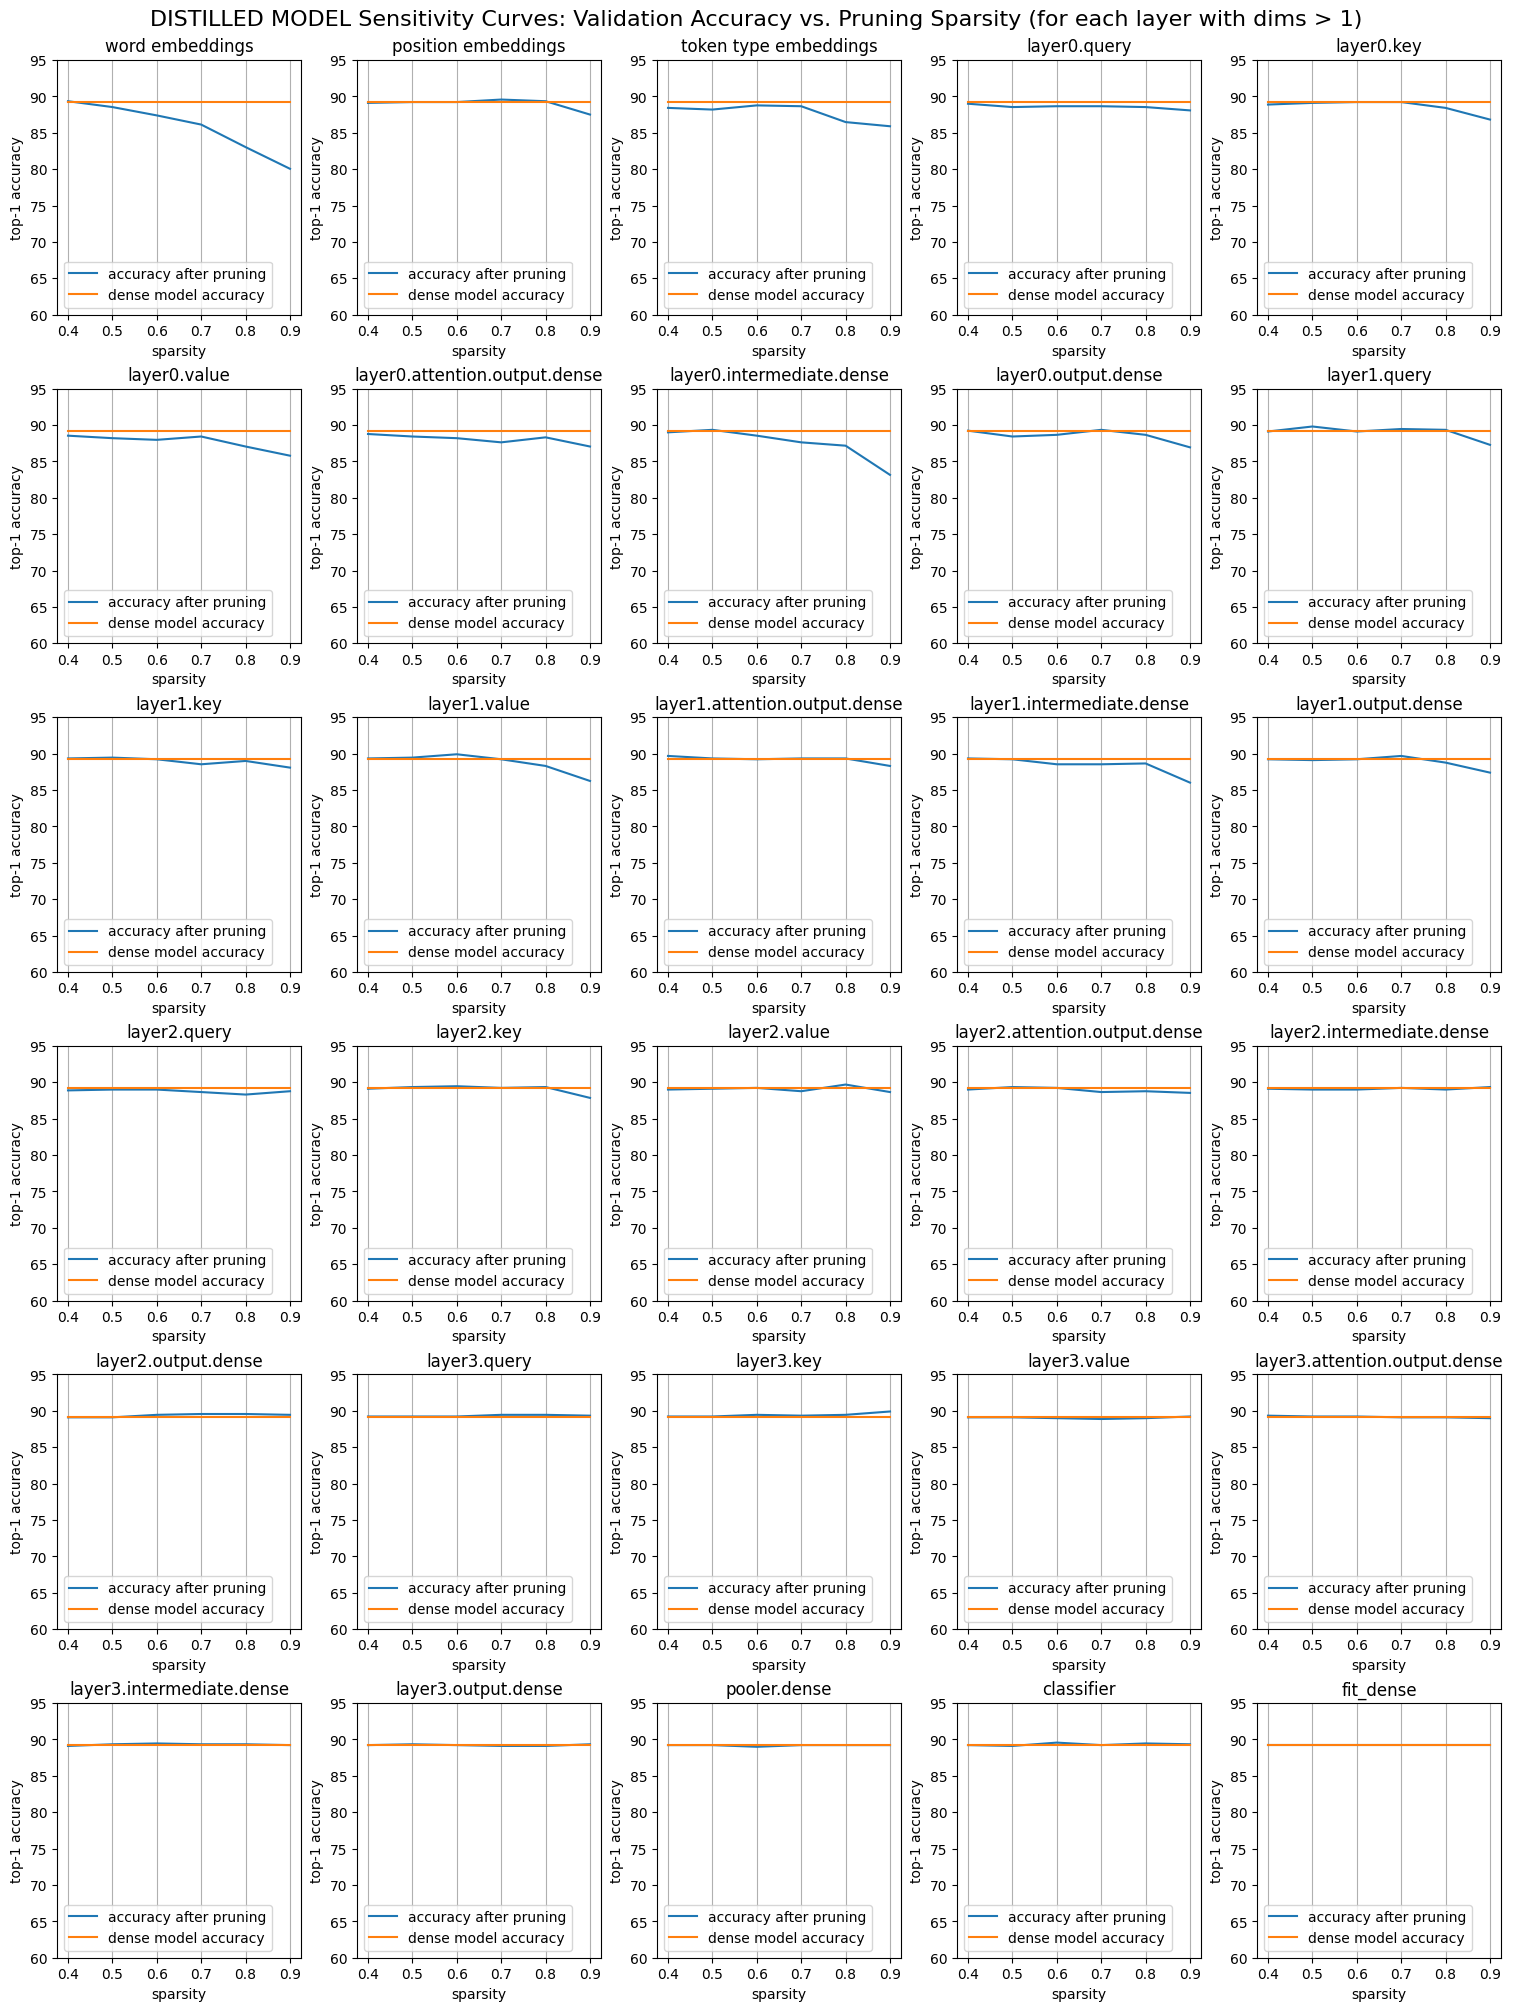

In [ ]:
import math
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    #lower_bound_accuracy = 100 - (100 - dense_model_accuracy) * 1.5
    lower_bound_accuracy = dense_model_accuracy # show dense model accuracy rather than a lower bound
    fig, axes = plt.subplots(6, int(math.ceil(len(accuracies) / 6)),figsize=(15,20), constrained_layout=True)
    axes = axes.ravel()
    plot_index = 0
    for name, param in student_model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [lower_bound_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(60, 95)
            ax.set_title("")
            # # format layer names for graph titles
            title = name.replace("bert.", "")
            title = title.replace("embeddings.word_embeddings", "word embeddings")
            title = title.replace("embeddings.position_embeddings", "position embeddings")
            title = title.replace("embeddings.token_type_embeddings", "token type embeddings")
            title = title.replace("encoder.layer.", "layer")
            title = title.replace("attention.self.query", "query")
            title = title.replace("attention.self.key", "key")
            title = title.replace("attention.self.value", "value")
            title = title.replace(".weight", "")
            ax.set_title(title)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('DISTILLED MODEL Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity (for each layer with dims > 1)', fontsize = 16)
    fig.subplots_adjust(top=0.96)
    # fig.tight_layout()
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

## Optimal Pruned Model

In [ ]:
dense_model = copy.deepcopy(student_model)

In [ ]:
# build sparsity dictionary
# TODO: fill in values based on results of sensitivity testing
sparsity_dict = {
'bert.embeddings.word_embeddings.weight':0.5,
'bert.embeddings.position_embeddings.weight':0.8,
'bert.embeddings.token_type_embeddings.weight':0.7,
'bert.encoder.layer.0.attention.self.query.weight':0.8,
'bert.encoder.layer.0.attention.self.key.weight':0.7,
'bert.encoder.layer.0.attention.self.value.weight':0.7,
'bert.encoder.layer.0.attention.output.dense.weight':0.8,
'bert.encoder.layer.0.intermediate.dense.weight':0.5,
'bert.encoder.layer.0.output.dense.weight':0.8,
'bert.encoder.layer.1.attention.self.query.weight':0.8,
'bert.encoder.layer.1.attention.self.key.weight':0.8,
'bert.encoder.layer.1.attention.self.value.weight':0.6,
'bert.encoder.layer.1.attention.output.dense.weight':0.8,
'bert.encoder.layer.1.intermediate.dense.weight':0.8,
'bert.encoder.layer.1.output.dense.weight':0.7,
'bert.encoder.layer.2.attention.self.query.weight':0.9,
'bert.encoder.layer.2.attention.self.key.weight':0.8,
'bert.encoder.layer.2.attention.self.value.weight':0.9,
'bert.encoder.layer.2.attention.output.dense.weight':0.9,
'bert.encoder.layer.2.intermediate.dense.weight':0.9,
'bert.encoder.layer.2.output.dense.weight':0.9,
'bert.encoder.layer.3.attention.self.query.weight':0.9,
'bert.encoder.layer.3.attention.self.key.weight':0.9,
'bert.encoder.layer.3.attention.self.value.weight':0.9,
'bert.encoder.layer.3.attention.output.dense.weight':0.9,
'bert.encoder.layer.3.intermediate.dense.weight':0.9,
'bert.encoder.layer.3.output.dense.weight':0.9,
'bert.pooler.dense.weight':0.9,
'classifier.weight':0.9,
'fit_dense.weight':0.9,
}

In [ ]:
pruner = FineGrainedPruner(student_model, sparsity_dict)

sparse_model_size = get_model_size(student_model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(student_model)['acc']*100
print("\n")
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% before fintuning")



Sparse model has size=21.84 MiB = 39.24% of dense model size


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 147.03it/s]



Sparse model has accuracy=49.08% before fintuning


## Fine-tuning the fine-grain pruned model

In [ ]:
student_model = train_tinybert_sst2(student_model)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


Training: 100%|██████████| 2105/2105 [00:49<00:00, 42.63it/s]


Training loss: 0.3304
Training accuracy: 0.8540


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.05it/s]


Validation loss: 0.3709
Validation accuracy: 0.8406


## Plots for finegrain pruning - TODO

# Channel Pruning - TODO

# K-means quantization

## k-means quantization functions

In [ ]:
from collections import namedtuple

Codebook = namedtuple('Codebook', ['centroids', 'labels'])

In [ ]:
from fast_pytorch_kmeans import KMeans

def k_means_quantize(fp32_tensor: torch.Tensor, bitwidth=4, codebook=None):
    """
    quantize tensor using k-means clustering
    :param fp32_tensor:
    :param bitwidth: [int] quantization bit width, default=4
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    :return:
        [Codebook = (centroids, labels)]
            centroids: [torch.(cuda.)FloatTensor] the cluster centroids
            labels: [torch.(cuda.)LongTensor] cluster label tensor
    """
    if codebook is None:
        ############### YOUR CODE STARTS HERE ###############
        # get number of clusters based on the quantization precision
        # hint: one line of code
        n_clusters = 2**bitwidth
        ############### YOUR CODE ENDS HERE #################
        # use k-means to get the quantization centroids
        kmeans = KMeans(n_clusters=n_clusters, mode='euclidean', verbose=0)
        labels = kmeans.fit_predict(fp32_tensor.view(-1, 1)).to(torch.long)
        centroids = kmeans.centroids.to(torch.float).view(-1)
        codebook = Codebook(centroids, labels)
    ############### YOUR CODE STARTS HERE ###############
    # decode the codebook into k-means quantized tensor for inference
    # hint: one line of code
    quantized_tensor = codebook.centroids[codebook.labels].view_as(fp32_tensor)
    ############### YOUR CODE ENDS HERE #################
    fp32_tensor.set_(quantized_tensor.view_as(fp32_tensor))
    return codebook

In [ ]:
def update_codebook(fp32_tensor: torch.Tensor, codebook: Codebook):
    """
    update the centroids in the codebook using updated fp32_tensor
    :param fp32_tensor: [torch.(cuda.)Tensor]
    :param codebook: [Codebook] (the cluster centroids, the cluster label tensor)
    """
    n_clusters = codebook.centroids.numel()
    fp32_tensor = fp32_tensor.view(-1)
    for k in range(n_clusters):
    ############### YOUR CODE STARTS HERE ###############
        # hint: one line of code
        # codebook.centroids[k] = torch.mean(fp32_tensor)
        # print("length of codebook labels:", len(codebook.labels))
        # print("length of fp32_tensor:", len(fp32_tensor))
        codebook.centroids[k] = torch.mean(fp32_tensor[codebook.labels == k])
    ############### YOUR CODE ENDS HERE #################

In [ ]:
from torch.nn import parameter
class KMeansQuantizer:
    def __init__(self, model : nn.Module, bitwidth=4):
        self.codebook = KMeansQuantizer.quantize(model, bitwidth)

    @torch.no_grad()
    def apply(self, model, update_centroids):
        for name, param in model.named_parameters():
            if name in self.codebook:
                if update_centroids:
                    update_codebook(param, codebook=self.codebook[name])
                self.codebook[name] = k_means_quantize(
                    param, codebook=self.codebook[name])

    @staticmethod
    @torch.no_grad()
    def quantize(model: nn.Module, bitwidth=4):
        codebook = dict()
        if isinstance(bitwidth, dict):
            for name, param in model.named_parameters():
                if name in bitwidth:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth[name])
        else:
            for name, param in model.named_parameters():
                if param.dim() > 1:
                    codebook[name] = k_means_quantize(param, bitwidth=bitwidth)
        return codebook

## Test k-means quantization

/content/Pretrained-Language-Model/TinyBERT/transformer/modeling.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location='cp

k-means quantizing model into 8 bits
    8-bit k-means quantized model has size=13.92 MiB


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 127.10it/s]


    8-bit k-means quantized model has accuracy=50.92%
k-means quantizing model into 4 bits
    4-bit k-means quantized model has size=6.96 MiB


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 122.33it/s]


    4-bit k-means quantized model has accuracy=50.92%
k-means quantizing model into 2 bits
    2-bit k-means quantized model has size=3.48 MiB


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 128.03it/s]


    2-bit k-means quantized model has accuracy=48.97%


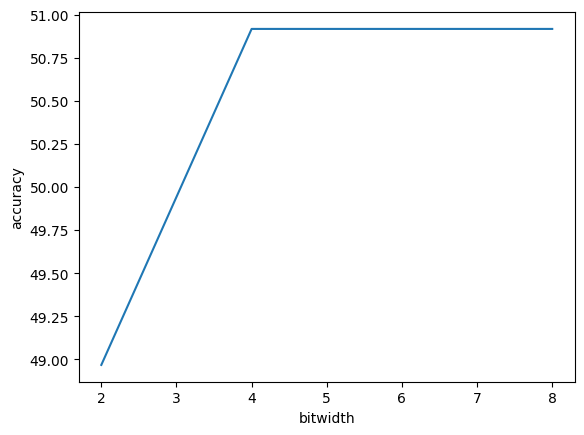

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantizers = dict()
bitwidths = [8, 4, 2]
accs = []
sizes = []
for bitwidth in bitwidths:

    student_model = TinyBertForSequenceClassification.from_pretrained(DISTILLED_CONFIG_DIR, num_labels=num_labels)

    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(student_model, bitwidth)
    quantized_model_size = get_model_size(student_model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    sizes.append(quantized_model_size)
    quantized_model_accuracy = evaluate(student_model)['acc'] *100
    accs.append(quantized_model_accuracy)
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

plt.plot(bitwidths, accs)
plt.xlabel('bitwidth')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# save accs, sizes, and bitwidths to a pickle file
import pickle
res_dict = {'accs': accs, 'sizes': sizes, 'bitwidths': bitwidths}
file_name = "DISTILLED_quant_no_finetuning_data.pkl"
with open(f'/content/{file_name}', 'wb') as f:
    pickle.dump(res_dict, f)

## Finetuning quantized model

We need a new training function for finetuning the quantized model because after each epoch we have to re-quantize the weights. The new method is modified only by additionally taking in the `quantizer` as a parameter and calling `quantizer.apply` after each epoch.

### finetuning quantized model methods

In [ ]:
def train_quantized_tinybert(
    model,
    quantizer,
    task_name,
    train_dataloader,
    eval_dataloader,
    device,
    output_mode,
    num_labels,
    eval_labels,
    optimizer=None,
    scheduler=None,
    epochs=3
):
    """
    Fine-tune a TinyBERT model with training and validation metrics history.

    Args:
        model: The TinyBERT model to be fine-tuned.
        task_name: Name of the task (used for metric computation).
        train_dataloader: DataLoader for training data.
        eval_dataloader: DataLoader for evaluation data.
        device: Device to train on (e.g., 'cpu' or 'cuda').
        output_mode: Output mode for the task ('classification' or 'regression').
        num_labels: Number of labels for classification tasks.
        eval_labels: Ground truth labels for the evaluation set.
        optimizer: Optimizer for training (default is AdamW).
        scheduler: Learning rate scheduler (optional).
        epochs: Number of training epochs.

    Returns:
        model: The fine-tuned model with a `history` attribute.
    """
    # Initialize optimizer if none is provided
    if optimizer is None:
        optimizer = AdamW(model.parameters(), lr=5e-5)

    # Initialize or extend model's history attribute
    if not hasattr(model, 'history'):
        model.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Move model to the specified device
    model.to(device)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0  # To track total training loss
        nb_train_steps = 0  # To count the number of training steps
        correct_predictions = 0
        total_predictions = 0

        print(f"Epoch {epoch + 1}/{epochs}")

        # Training step
        for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
            # Move each tensor in the batch to the device
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch

            # Zero the gradients to prevent accumulation
            optimizer.zero_grad()

            # Forward pass
            logits, _, _ = model(input_ids, segment_ids, input_mask)

            # Compute loss
            if output_mode == "classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
                preds = torch.argmax(logits, dim=1)
            elif output_mode == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), label_ids.view(-1))
                preds = logits.squeeze()
            else:
                raise ValueError(f"Unknown output mode: {output_mode}")

            # Update metrics
            if output_mode == "classification":
                correct_predictions += (preds == label_ids).sum().item()
                total_predictions += label_ids.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # apply the quantization
            quantizer.apply(model, update_centroids=False)

            # Update training metrics
            total_loss += loss.item()
            nb_train_steps += 1

        # Adjust learning rate with scheduler (if provided)
        if scheduler:
            scheduler.step()

        # Compute training metrics
        avg_train_loss = total_loss / nb_train_steps
        train_accuracy = correct_predictions / total_predictions if output_mode == "classification" else None
        print(f"Training loss: {avg_train_loss:.4f}")
        if train_accuracy is not None:
            print(f"Training accuracy: {train_accuracy:.4f}")

        # Evaluate the model
        eval_result = evaluate_tinybert(
            model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels
        )
        avg_val_loss = eval_result['eval_loss']
        val_accuracy = eval_result['acc']

        # Print validation results
        print(f"Validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f}")

        # Update the model's history
        model.history['train_loss'].append(avg_train_loss)
        model.history['val_loss'].append(avg_val_loss)
        if train_accuracy is not None:
            model.history['train_acc'].append(train_accuracy)
        model.history['val_acc'].append(val_accuracy)

    return model


In [ ]:
# putting the dataset prep and training into one function

def train_quantized_tinybert_sst2(student_model, quantizer):
  # building the train and evaluation dataloader
  do_lower_case = False
  data_dir = '/content/SST-2'
  processor = Sst2Processor()
  label_list = processor.get_labels()
  num_labels = len(label_list)
  max_seq_length = 128
  eval_batch_size = 32
  train_batch_size = 32
  task_name = "sst2"
  output_mode = "classification"
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # student_model = TinyBertForSequenceClassification.from_pretrained(STUDENT_CONFIG_DIR, num_labels=num_labels)
  student_model.to(device)

  tokenizer = BertTokenizer.from_pretrained(STUDENT_CONFIG_DIR, do_lower_case=do_lower_case)
  eval_examples = processor.get_dev_examples(data_dir)
  eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
  eval_data, eval_labels = get_tensor_data(output_mode, eval_features)
  eval_sampler = SequentialSampler(eval_data)
  eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

  train_examples = processor.get_train_examples(data_dir)
  train_features = convert_examples_to_features(train_examples, label_list, max_seq_length, tokenizer, output_mode)
  train_data, train_labels = get_tensor_data(output_mode, train_features)
  train_sampler = SequentialSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

  # only train for 1 epoch - overfits fast
  student_model = train_quantized_tinybert(
      student_model,
      quantizer,
      task_name,
      train_dataloader,
      eval_dataloader,
      device,
      output_mode,
      num_labels,
      eval_labels,
      optimizer=None,
      scheduler=None,
      epochs=1
  )
  return student_model

### Run the Finetuning

/content/Pretrained-Language-Model/TinyBERT/transformer/modeling.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location='cp

k-means quantizing model into 8 bits
FINETUNING 8-bit model


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


Training: 100%|██████████| 2105/2105 [00:51<00:00, 40.67it/s]


Training loss: 0.6555
Training accuracy: 0.6391


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 147.88it/s]


Validation loss: 0.6375
Validation accuracy: 0.7913
    8-bit k-means quantized model has size=13.92 MiB


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.38it/s]


    8-bit k-means quantized model has accuracy=79.13%
k-means quantizing model into 4 bits
FINETUNING 4-bit model
Epoch 1/1


Training: 100%|██████████| 2105/2105 [00:51<00:00, 40.79it/s]


Training loss: 0.6604
Training accuracy: 0.6017


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.21it/s]


Validation loss: 0.6444
Validation accuracy: 0.7775
    4-bit k-means quantized model has size=6.96 MiB


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.83it/s]


    4-bit k-means quantized model has accuracy=77.75%
k-means quantizing model into 2 bits
FINETUNING 2-bit model
Epoch 1/1


Training: 100%|██████████| 2105/2105 [00:51<00:00, 40.69it/s]


Training loss: 0.6852
Training accuracy: 0.5581


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.44it/s]


Validation loss: 0.6860
Validation accuracy: 0.5092
    2-bit k-means quantized model has size=3.48 MiB


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.25it/s]


    2-bit k-means quantized model has accuracy=50.92%


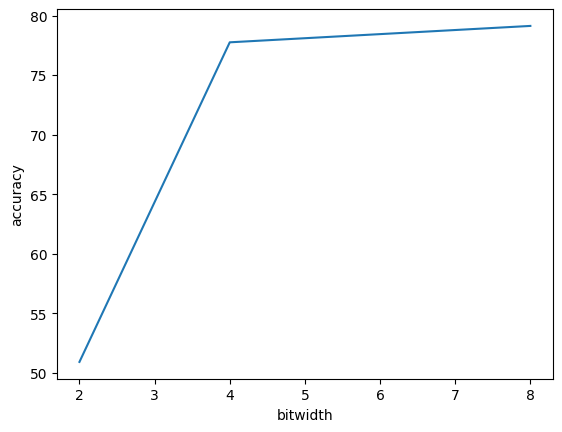

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantizers = dict()
bitwidths = [8, 4, 2]
accs = []
sizes = []
for bitwidth in bitwidths:
    # student_model = load_original_model()
    # student_model.to(device)
    # student_model = nn.DataParallel(student_model)
    student_model = TinyBertForSequenceClassification.from_pretrained(DISTILLED_CONFIG_DIR, num_labels=num_labels)
    student_model.to(device)

    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(student_model, bitwidth)

    # finetune quantized model
    print(f"FINETUNING {bitwidth}-bit model")
    student_model = train_quantized_tinybert_sst2(student_model, quantizer)

    quantized_model_size = get_model_size(student_model, bitwidth)
    print(f"    {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")
    sizes.append(quantized_model_size)
    quantized_model_accuracy = evaluate(student_model)['acc'] *100
    accs.append(quantized_model_accuracy)
    print(f"    {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

plt.plot(bitwidths, accs)
plt.xlabel('bitwidth')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# save accs, sizes, and bitwidths to a pickle file
import pickle
res_dict = {'accs': accs, 'sizes': sizes, 'bitwidths': bitwidths}
file_name = "DISTILLED_quant_WITH_finetuning_data.pkl"
with open(f'/content/{file_name}', 'wb') as f:
    pickle.dump(res_dict, f)

# Pruning AND Quantization Together

## Apply Pruning and Quantization without Finetuning

/content/Pretrained-Language-Model/TinyBERT/transformer/modeling.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location='cp

pruning...
  pruned model has size=21.84 MiB
k-means quantizing model into 8 bits
    pruned 8-bit k-means quantized model has size=5.46 MiB


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 125.15it/s]


    pruned 8-bit k-means quantized model has accuracy=49.08%
pruning...
  pruned model has size=21.84 MiB
k-means quantizing model into 4 bits
    pruned 4-bit k-means quantized model has size=3.02 MiB


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 123.48it/s]


    pruned 4-bit k-means quantized model has accuracy=49.08%
pruning...
  pruned model has size=21.84 MiB
k-means quantizing model into 2 bits
    pruned 2-bit k-means quantized model has size=3.19 MiB


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 123.82it/s]


    pruned 2-bit k-means quantized model has accuracy=50.92%


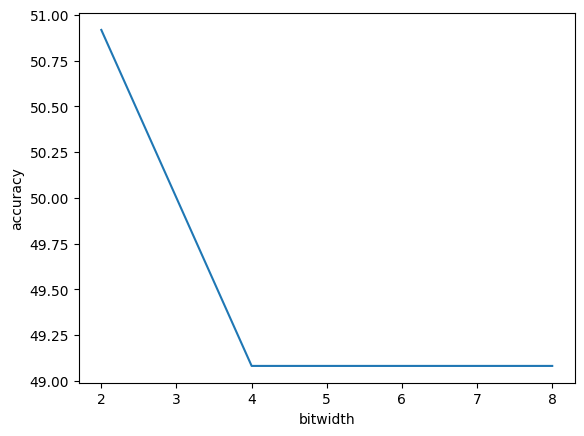

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantizers = dict()
bitwidths = [8, 4, 2]
accs = []
sparse_sizes = []
final_sizes = []
for bitwidth in bitwidths:
    # student_model = load_original_model()
    # student_model.to(device)
    # student_model = nn.DataParallel(student_model)
    student_model = TinyBertForSequenceClassification.from_pretrained(DISTILLED_CONFIG_DIR, num_labels=num_labels)

    print("pruning...")
    pruner = FineGrainedPruner(student_model, sparsity_dict)
    # before quantizing, the bitwidth is 32
    sparse_model_size = get_model_size(student_model, data_width=32, count_nonzero_only=True)
    sparse_sizes.append(sparse_model_size)
    print(f"  pruned model has size={sparse_model_size/MiB:.2f} MiB")

    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(student_model, bitwidth)
    quantized_model_size = get_model_size(student_model, data_width=bitwidth, count_nonzero_only=True)
    final_sizes.append(quantized_model_size)
    print(f"    pruned {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")

    quantized_model_accuracy = evaluate(student_model)['acc'] *100
    accs.append(quantized_model_accuracy)
    print(f"    pruned {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

plt.plot(bitwidths, accs)
plt.xlabel('bitwidth')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# save accs, sizes, and bitwidths to a pickle file
import pickle
res_dict = {'accs': accs, 'sparse_sizes': sparse_sizes, 'final_sizes': final_sizes, 'bitwidths': bitwidths}
file_name = "DISTILLED_prune_and_quant_NO_finetuning_data.pkl"
with open(f'/content/{file_name}', 'wb') as f:
    pickle.dump(res_dict, f)

## finetuning pruned+quantized model functions

When finetuning a pruned and quantized model, we need to apply both the pruner and quantizer after each epoch.

In [ ]:
def train_pruned_quantized_tinybert(
    model,
    quantizer,
    pruner,
    task_name,
    train_dataloader,
    eval_dataloader,
    device,
    output_mode,
    num_labels,
    eval_labels,
    optimizer=None,
    scheduler=None,
    epochs=3
):
    """
    Fine-tune a TinyBERT model with training and validation metrics history.

    Args:
        model: The TinyBERT model to be fine-tuned.
        task_name: Name of the task (used for metric computation).
        train_dataloader: DataLoader for training data.
        eval_dataloader: DataLoader for evaluation data.
        device: Device to train on (e.g., 'cpu' or 'cuda').
        output_mode: Output mode for the task ('classification' or 'regression').
        num_labels: Number of labels for classification tasks.
        eval_labels: Ground truth labels for the evaluation set.
        optimizer: Optimizer for training (default is AdamW).
        scheduler: Learning rate scheduler (optional).
        epochs: Number of training epochs.

    Returns:
        model: The fine-tuned model with a `history` attribute.
    """
    # Initialize optimizer if none is provided
    if optimizer is None:
        optimizer = AdamW(model.parameters(), lr=5e-5)

    # Initialize or extend model's history attribute
    if not hasattr(model, 'history'):
        model.history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # Move model to the specified device
    model.to(device)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0  # To track total training loss
        nb_train_steps = 0  # To count the number of training steps
        correct_predictions = 0
        total_predictions = 0

        print(f"Epoch {epoch + 1}/{epochs}")

        # Training step
        for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
            # Move each tensor in the batch to the device
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids, seq_lengths = batch

            # Zero the gradients to prevent accumulation
            optimizer.zero_grad()

            # Forward pass
            logits, _, _ = model(input_ids, segment_ids, input_mask)

            # Compute loss
            if output_mode == "classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, num_labels), label_ids.view(-1))
                preds = torch.argmax(logits, dim=1)
            elif output_mode == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), label_ids.view(-1))
                preds = logits.squeeze()
            else:
                raise ValueError(f"Unknown output mode: {output_mode}")

            # Update metrics
            if output_mode == "classification":
                correct_predictions += (preds == label_ids).sum().item()
                total_predictions += label_ids.size(0)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # apply the pruning and quantization
            pruner.apply(model)
            quantizer.apply(model, update_centroids=True)

            # Update training metrics
            total_loss += loss.item()
            nb_train_steps += 1

        # Adjust learning rate with scheduler (if provided)
        if scheduler:
            scheduler.step()

        # Compute training metrics
        avg_train_loss = total_loss / nb_train_steps
        train_accuracy = correct_predictions / total_predictions if output_mode == "classification" else None
        print(f"Training loss: {avg_train_loss:.4f}")
        if train_accuracy is not None:
            print(f"Training accuracy: {train_accuracy:.4f}")

        # Evaluate the model
        eval_result = evaluate_tinybert(
            model, task_name, eval_dataloader, device, output_mode, eval_labels, num_labels
        )
        avg_val_loss = eval_result['eval_loss']
        val_accuracy = eval_result['acc']

        # Print validation results
        print(f"Validation loss: {avg_val_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f}")

        # Update the model's history
        model.history['train_loss'].append(avg_train_loss)
        model.history['val_loss'].append(avg_val_loss)
        if train_accuracy is not None:
            model.history['train_acc'].append(train_accuracy)
        model.history['val_acc'].append(val_accuracy)

    return model


In [ ]:
# putting the dataset prep and training into one function

def train_pruned_quantized_tinybert_sst2(student_model, quantizer, pruner):
  # building the train and evaluation dataloader
  do_lower_case = False
  data_dir = '/content/SST-2'
  processor = Sst2Processor()
  label_list = processor.get_labels()
  num_labels = len(label_list)
  max_seq_length = 128
  eval_batch_size = 32
  train_batch_size = 32
  task_name = "sst2"
  output_mode = "classification"
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  # student_model = TinyBertForSequenceClassification.from_pretrained(STUDENT_CONFIG_DIR, num_labels=num_labels)
  student_model.to(device)

  tokenizer = BertTokenizer.from_pretrained(STUDENT_CONFIG_DIR, do_lower_case=do_lower_case)
  eval_examples = processor.get_dev_examples(data_dir)
  eval_features = convert_examples_to_features(eval_examples, label_list, max_seq_length, tokenizer, output_mode)
  eval_data, eval_labels = get_tensor_data(output_mode, eval_features)
  eval_sampler = SequentialSampler(eval_data)
  eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=eval_batch_size)

  train_examples = processor.get_train_examples(data_dir)
  train_features = convert_examples_to_features(train_examples, label_list, max_seq_length, tokenizer, output_mode)
  train_data, train_labels = get_tensor_data(output_mode, train_features)
  train_sampler = SequentialSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=train_batch_size)

  # only train for 1 epoch - overfits fast
  student_model = train_pruned_quantized_tinybert(
      student_model,
      quantizer,
      pruner,
      task_name,
      train_dataloader,
      eval_dataloader,
      device,
      output_mode,
      num_labels,
      eval_labels,
      optimizer=None,
      scheduler=None,
      epochs=1
  )
  return student_model

## run finetuning on pruned and quantized model

/content/Pretrained-Language-Model/TinyBERT/transformer/modeling.py:696: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location='cp

pruning...
  pruned model has size=21.84 MiB
k-means quantizing model into 8 bits
    pruned 8-bit k-means quantized model has size=5.46 MiB
FINETUNING pruned 8-bit model


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/1


Training: 100%|██████████| 2105/2105 [28:27<00:00,  1.23it/s]


Training loss: 0.6880
Training accuracy: 0.5578


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.74it/s]


Validation loss: 0.6952
Validation accuracy: 0.5092


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.25it/s]


    pruned 8-bit k-means quantized model has accuracy=50.92%
pruning...
  pruned model has size=21.84 MiB
k-means quantizing model into 4 bits
    pruned 4-bit k-means quantized model has size=2.93 MiB
FINETUNING pruned 4-bit model
Epoch 1/1


Training: 100%|██████████| 2105/2105 [02:45<00:00, 12.76it/s]


Training loss: 0.6887
Training accuracy: 0.5578


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 144.79it/s]


Validation loss: 0.6955
Validation accuracy: 0.5092


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.34it/s]


    pruned 4-bit k-means quantized model has accuracy=50.92%
pruning...
  pruned model has size=21.84 MiB
k-means quantizing model into 2 bits
    pruned 2-bit k-means quantized model has size=3.16 MiB
FINETUNING pruned 2-bit model
Epoch 1/1


Training: 100%|██████████| 2105/2105 [01:24<00:00, 24.83it/s]


Training loss: 0.6906
Training accuracy: 0.5575


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.90it/s]


Validation loss: 0.6934
Validation accuracy: 0.5092


Evaluating: 100%|██████████| 28/28 [00:00<00:00, 145.92it/s]


    pruned 2-bit k-means quantized model has accuracy=50.92%


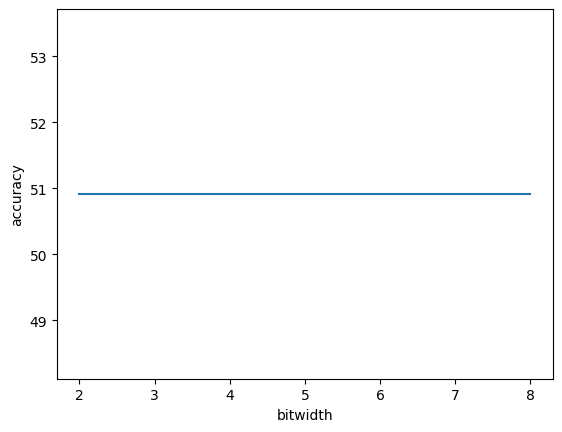

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantizers = dict()
bitwidths = [8, 4, 2]
accs = []
sizes = []
sparse_sizes = []
final_sizes = []
for bitwidth in bitwidths:
    # student_model = load_original_model()
    # student_model.to(device)
    # student_model = nn.DataParallel(student_model)
    student_model = TinyBertForSequenceClassification.from_pretrained(STUDENT_CONFIG_DIR, num_labels=num_labels)
    student_model.to(device)

    print("pruning...")
    pruner = FineGrainedPruner(student_model, sparsity_dict)
    # before quantizing, the bitwidth is 32
    sparse_model_size = get_model_size(student_model, data_width=32, count_nonzero_only=True)
    sparse_sizes.append(sparse_model_size)
    print(f"  pruned model has size={sparse_model_size/MiB:.2f} MiB")

    print(f'k-means quantizing model into {bitwidth} bits')
    quantizer = KMeansQuantizer(student_model, bitwidth)
    quantized_model_size = get_model_size(student_model, data_width=bitwidth, count_nonzero_only=True)
    final_sizes.append(quantized_model_size)
    print(f"    pruned {bitwidth}-bit k-means quantized model has size={quantized_model_size/MiB:.2f} MiB")

    # finetune quantized model
    print(f"FINETUNING pruned {bitwidth}-bit model")
    student_model = train_pruned_quantized_tinybert_sst2(student_model, quantizer, pruner)

    quantized_model_accuracy = evaluate(student_model)['acc'] *100
    accs.append(quantized_model_accuracy)
    print(f"    pruned {bitwidth}-bit k-means quantized model has accuracy={quantized_model_accuracy:.2f}%")
    quantizers[bitwidth] = quantizer

plt.plot(bitwidths, accs)
plt.xlabel('bitwidth')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# save accs, sizes, and bitwidths to a pickle file
import pickle
res_dict = {'accs': accs, 'sparse_sizes': sparse_sizes, 'final_sizes': final_sizes, 'bitwidths': bitwidths}
file_name = "DISTILLED_prune_and_quant_WITH_finetuning_data.pkl"
with open(f'/content/{file_name}', 'wb') as f:
    pickle.dump(res_dict, f)